# TP2 : k-Nearest Neighbor (k-NN) and linear transformations - OBLIGATORY

In this TP you will implement a simple nearest Neighbors classifier using Python. 

First you will implement euclidean distance in three different ways (2 loops, 1 loop, without any loop) to see and understand the importance of the vectorization. Then you will train the kNN algorithm for a number of neighbors k, to check and comment on the model complexity. 
You will also implement the Mahalanobis distance and comment on the effect of a transformation on this distance.

The k-NN classifier consists of two stages:  
- During training, the classifier takes the training data and simply remembers it
- During testing, k-NN classifies every test sample by comparing to all training samples and transfering the labels of the k most similar training examples



In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_IRIS, load_CIFAR10
import matplotlib.pyplot as plt

# make figures appear inline
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

First, we will use a dataset named CIFAR10. This dataset contains 60,000 32x32 color images in 10 different classes ([CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10)) and it will allow us to compare the three different implementations of Euclidean distance.

**You have to download the dataset; open a terminal and go to the folder *datasets*, then execute the script *get_datasets.sh*:**
```bash
$ ./get_datasets.sh
```

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


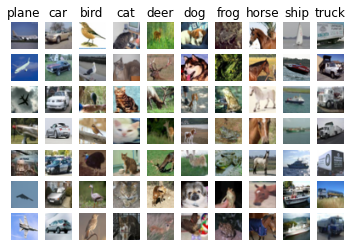

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)



(5000, 3072) (500, 3072)


Now that we have the data we can focus on k-NN precisely. We will start by implementing the Euclidean distance with two loops and check that the implementation is correct before moving forward.

The k-NN algorithm can be broken down into two steps:
- The first step is to calculate the distances between each sample of the test set and those of the training set. This distances will be stored in a matrix of shape (number of test samples, number of training samples) where each element (i,j) is the distance between the i-th test and j-th train example.
- The second is to use this distance matrix to find the closest neighbors of each individual in the test set.

Let's start with implementation :  
Go to `distances.py` and implement the function `compute_euclidean_dist_two_loops`. This function uses a very inefficient double loop to compute the distance matrix one element at time.


Recall:  
The euclidean distance between two learning instances $x_i \in R^d$ and $x_j \in R^d$, where $d$ is the feature (attribute) dimention, is simply defined as:
$d_2(x_i, x_j) = \sqrt{(x_i-x_j)^T(x_i - x_j)} = \sum \sqrt{(x_i-x_j)^2}$ 

In [6]:
# Open distances.py and implement compute_euclidean_dist_two_loops.
from distances import compute_euclidean_dist_two_loops

# Test your implementation, this should output (500,5000)
dists = compute_euclidean_dist_two_loops(X_train, X_test)
print(dists.shape)

(500, 5000)


To verify that your implementation is correct implement the prediction step.

Go to `k_nearest_neighbor.py` and implement the `predict_labels` method.

You should expect to see approximately `27%` accuracy.

In [20]:
from k_nearest_neighbor import KNearestNeighbor
# Create a k-NN classifier instance. 
# Remember that training a k-NN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
knn = KNearestNeighbor()
knn.train(X_train, y_train)

# Don't forget to implement the following method in k_nearest_neighbor.py
# We use k = 1 (which is the Nearest Neighbor).

y_test_pred = knn.predict_labels(dists, k=1)
print(y_test_pred.shape)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = (float(num_correct) / num_test)*100
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

(50,)
Got 46 / 500 correct => accuracy: 9.200000


Now lets try out a larger `k`, say `k = 5`. You should expect a slightly better performance than with `k = 1`.

In [8]:
y_test_pred = knn.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = (float(num_correct) / num_test)*100
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 29.000000


If your implementation gives you the accuracy expected, well done !

Now lets improve the performance of the algorithm ! 

We ask you to implement the function `compute_euclidean_dist_one_loop` in `distances.py`.

In [9]:
# Open distances.py and implement compute_euclidean_dist_two_loops.
from distances import compute_euclidean_dist_one_loop

dists_one = compute_euclidean_dist_one_loop(X_train, X_test)

# To ensure that your new implementation is correct, the test below will compare it to the naive one using the norm.
# You should expect a value close to 0.

difference = np.linalg.norm(dists - dists_one)
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


This implementation should improve the computational time, but we can do better!

To make the code really fast you have to avoid the use of loops. To achieve this you should vectorize the code using the matrix operations that numpy provide you.

Implement the missing part of the function `compute_euclidean_dist_no_loops` in `distances.py`.

In [22]:
# Open distances.py and implement compute_euclidean_dist_no_loops.
from distances import compute_euclidean_dist_no_loops

dists_no = compute_euclidean_dist_no_loops(X_train, X_test)

# To ensure that your new implementation is correct, the test below will compare it to the naive one using the norm.
# You should expect a value close to 0.

difference = np.linalg.norm(dists - dists_no)
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [7]:
# Let's compare how fast the implementations are
from distances import compute_euclidean_dist_one_loop
from distances import compute_euclidean_dist_no_loops
from distances import compute_euclidean_dist_two_loops
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(compute_euclidean_dist_two_loops, X_train, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(compute_euclidean_dist_one_loop, X_train, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(compute_euclidean_dist_no_loops, X_train, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 40.104608 seconds
One loop version took 44.307155 seconds
No loop version took 0.319101 seconds


## Iris dataset: model complexity and decision surfaces

Now that we have seen the effect of loops in the code, we will see how k affects the model. To simplify this part we  introduce a new dataset named [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). This dataset has 150 samples from 3 classes, 50 from each one (Iris setosa, Iris virginica and Iris versicolor) and each sample has 4 attributes (Sepal Length, Sepal Width, Petal Length and Petal Width). 


In [8]:
# Load the Iris data.
# Cleaning up variables to prevent loading data multiple times (which may cause memory issues)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_IRIS(test=True)

# As a sanity check, we print out the size of the training and test data.
# we use all the data as training
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (100, 4)
Training labels shape:  (100,)
Test data shape:  (50, 4)
Test labels shape:  (50,)


### Mahalanobis distance

The mahalanobis distance is parametrized by a $d \times d$ covariance matrix $\Sigma$, in which case the metric is defined as:  

$d(x_i, x_j; \Sigma) = \sqrt{(x_i-x_j)^T\Sigma^{-1}(x_i - x_j)}$  

where we can see that the euclidean distance is simply the mahalanobis distance with the identity matrix I as covariance matrix.

Implement the missing part in `compute_mahalanobis_dist` in `distances.py`. You are free to implement it the way you prefer (1 for loop, 2 for loops, or without for loop).

Now we will compute the Machalanobis distance using the identity covariance matrix and we will compare it with the result we get using the Euclidean distance. 



In [17]:
# Open distances.py and implement compute_mahalanobis_dist.
from distances import compute_mahalanobis_dist, compute_euclidean_dist_one_loop
from distances import define_covariance


# euclidean distance for testing
dists = compute_euclidean_dist_one_loop(X_train, X_test)

# mahalanobis distance
d = X_train.shape[1]
identity = np.identity(d)
dists_maha = compute_mahalanobis_dist(X_train, X_test, identity)

# To ensure that your new implementation is correct, the test below will compare it to the naive one using the norm.
# You should expect a value close to 0.

difference = np.linalg.norm(dists - dists_maha)
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


## Manhattan distance
Implement the missing part in `compute_manhattan_dist` in `distances.py`. You are free to implement it the way you prefer (1 for loop, 2 for loops, or without for loop).

In [18]:
# Open distances.py and implement compute_manhattan_dis.
from distances import compute_manhattan_dist

# manhattan distance
d = X_train.shape[1]
dists_manhattan = compute_manhattan_dist(X_train, X_test)




## Model complexity
Run the kNN algorithm using the iris data set with **1, 3, 5, 10, 25, 50 neighbors. For each k use the Euclidean, the Mahalanobis, and the Manhattan  distance. **

In the case of the Mahalanobis distance you are going to explore three different approaches to compute it. 

1. Define Σ as a diagonal matrix that has at its diagonal the average varianceof the different features, i.e. all diagonal entries $Σ_{ii}$ will be the same.
2. Define Σ as a diagonal matrix that has at its diagonal the variance of eachfeature, i.e.$σ_k$.
3. Define Σ as the full covariance matrix between all pairs of features.


Explain how the performance changes with respect to the values of k and the diffent distances that you use. How does the number of the neighbors influence the classification?

For a fixed number of neighbors (k= 10)  comment on the differences between the distances and on the differences between the three different versions of the Mahalanobis distances. Comment how these affect the performance of the classification, when we should prefer the oneover the other, etc..

In [22]:
from distances import compute_manhattan_dist, compute_mahalanobis_dist, compute_euclidean_dist_one_loop
from distances import define_covariance
from k_nearest_neighbor import KNearestNeighbor

# train
knn = KNearestNeighbor()
knn.train(X_train, y_train)

# test
k_values = [1, 3, 5, 10, 25, 50]
n = len(X_test)
distances = ['euclidean', 'mahalanobis', 'manhattan']
covariances = ['diag_average_cov', 'diag_cov', 'full_cov']

################################################################################
# TODO:                                                                        #
# Open distances.py and                                                        #
#   - implement compute_mahalanobis_dist,compute_manhattan_dist .              #
#   - implement define_covariance to computethe different covariance matrices  # 
#       approaches for the Machalanobis distance   
#                                                                              #
#                                                                              #
# run the kNN algorithm and compute the accuracy                               # 
#     - for the different k_values and the different distances                 #
#     - in the case of Machalanobis distance for the 3 different sigma cases   #
#
# For each case print the k, distance, sigma, number of corrects over the total #
# and the test accuray (similarly as we did above)
# (for example you have to print something like:  
#
#        mahalanobis distance, cov = diag_cov:                                         #
#        For k=10 Got 49 / 50 correct => accuracy: 0.98                           #
################################################################################
# Your code



################################################################################
#                                 END OF YOUR CODE                             #
################################################################################




## Decision surface
Visualize, study, and discuss the decision surfaces that kNN algorithm produces for the different values of k using the euclidean distance.


* To do so, you will work only in two attributes.

     * Testing will be done on an artificially generated dataset that covers in a regular manner all possible values for the two chosen attributes. To do so we need to divide the space into a grid by discretizing the space  into $n$ values between the minimum and maximum value of an attribute. Each of these values must be compared with the $n$ discrete values of the second attribute. The resulting array will be of shape $(n*n, 2)$
     
     * Using your training set classify your test instances and visualize the results of the classification
     
See how the performance changes with respect to the value of k. Explain how the different values of the k change the classification boundaries in the instance space for a given training set. 



In [ ]:
# Load the Iris data.
# Cleaning up variables to prevent loading data multiple times (which may cause memory issues)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train = load_IRIS(test=False)

# As a sanity check, we print out the size of the training and test data.
# we use all the data as training
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

In [ ]:
axes_labels = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

# For our visualisation we will only keep the two first attributs.
# You can choose 2 attribus here
attribut_1 = 1
attribut_2 = 3

X_train_2_features = np.array([X_train[:,attribut_1], X_train[:,attribut_2]]).T
axes_label_1 = axes_labels[attribut_1]
axes_label_2 = axes_labels[attribut_2]

# and the test set will be the matrix (n*n, 2) where n is the number of values taken between
# the min and the max of each attribute
n = 150

X_test = np.zeros((n*n, 2))
tmp = np.linspace(np.min(X_train_2_features[:, 0])-0.1, np.max(X_train_2_features[:, 0])+0.1, n)
X_test[:,0] = np.repeat(tmp, n)

tmp = np.linspace(np.min(X_train_2_features[:, 1])-0.1, np.max(X_train_2_features[:, 1])+0.1, n)
X_test[:,1] = np.tile(tmp, n)


print('Training data shape: ', X_train_2_features.shape)
print('Testing data shape: ', X_test.shape)

In [ ]:
# train
knn = KNearestNeighbor()
knn.train(X_train_2_features, y_train)

# test
k_values = [1, 3, 5, 10, 25, 50]
y_predicted_for_each_k = np.zeros((n*n ,len(k_values)))

for i in range(len(k_values)):
    y_predicted_for_each_k[:, i] = knn.predict(X_test, k=k_values[i], distance='euclidean', num_loops=0)
            



print('Predicted data shape (n, number of k values): ', y_predicted_for_each_k.shape)

In [ ]:
# plot the decision surface
colors_surfaces = ['#88E2EA', '#FFE1BB', '#D4F3CD']
colors_points = ['blue', 'red', 'green']

plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.clf()
fig = plt.figure() 

for i in range(len(k_values)):
    for n_class in range(3):
        x_train_attri_1 = X_train_2_features[y_train == n_class, 0]
        x_train_attri_2 = X_train_2_features[y_train == n_class, 1]
        
        x_test_attri_1 = X_test[y_predicted_for_each_k[:, i] == n_class, 0]
        x_test_attri_2 = X_test[y_predicted_for_each_k[:, i] == n_class, 1]
        
        ax = fig.add_subplot(2,3,1+i)  
        ax.set_title("K = "+str(k_values[i]))
        ax.scatter(x_test_attri_1, x_test_attri_2, s=15, color=colors_surfaces[n_class])
        ax.scatter(x_train_attri_1, x_train_attri_2, s=15, color=colors_points[n_class])
        ax.set_xlabel(axes_label_1)
        ax.set_ylabel(axes_label_2)

        
# each color represent a class of the problem

# don't take care of the warning

# Linear transformations

In this exercise we are interested in the effect of a linear transformation on distances. You will need to generate points to form a unit circle and draw it. Then you have to transform your set of points with a given matrix A.
You then have to redraw the unit circle with the points obtained and comment what you see.
Finally you have to find the points such that after transformation we have the same points as those generated for the unit circle. The goal here is  to visualize that even a small transformation puts you in a new space where the distances are different.

Explain the result of each transformation that you apply.


### Unit circle
Remember that the unit cicle is given from the equation $\,  x^2 + y^2 = 1$ and in a matrix notation is written as $\, X^TX = 1$

Coding tip: you create the x variable, then y is defined from x. This means that for each x, the corresponding y value is calculated (and thus y has the same shape as x).

In [ ]:
import numpy as np
# Open transformation.py and implement unit_circle_points and draw.
from transformation import setup_plot, draw, unit_circle_points

# get axes for the plots
fig, ax = setup_plot()

# number of points to divide the space
n = 400
# get the points of the unit circle
# X: A numpy array of shape (2, 2*n) where 
# X[0, :] is the set of points for the first coordinate x1 and 
# X[1, :] is the set of points for the second coordinate x2.

X = unit_circle_points(n)

# We print out the size of X, is it equal to (2, 800) ? 
print("Shape of X :", X.shape)

# draw the unit circle
draw(ax, X, n, 'green')

In [ ]:
# Open transformation.py and implement apply_transformation_AX.
from transformation import apply_transformation_AX

fig, ax = setup_plot()

# redraw the unit circle
draw(ax, X, n, 'green')

# define the transformation matrix
A = np.array([[0.8, 0.3], [0.3, 0.8]])



# apply the transformation
AX = apply_transformation_AX(X, A)


# We print out the size of AX, is it equal to (2, 800) ? 
print("Shape of AX :", AX.shape)

# draw the unit circle after transformation
draw(ax, AX, n, 'blue')

### First transformation
explain.

In [ ]:
# Open transformation.py and implement apply_transformation_Z.
from transformation import apply_transformation_Z

fig, ax = setup_plot()

# redraw the unit circle
draw(ax, X, n, 'green')
# redraw the transformed circle
draw(ax, AX, n, 'blue')

# apply the transformation
Z = apply_transformation_Z(X, A)

# We print out the size of Z, is it equal to (2, 800) ? 
print("Shape of Z :", Z.shape)

# draw the unit circle after transformation with condition
draw(ax, Z, n, 'red')

comment the result